# Tutorial 5: Advanced DL Networks
## Laura E. Boucheron, Electrical & Computer Engineering, NMSU
### October 2020
Copyright (C) 2020  Laura E. Boucheron

This information is free; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 3 of the License, or (at your option) any later version.

This work is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this work; if not, If not, see <https://www.gnu.org/licenses/>.

## Overview
In this tutorial, we study some more deep learning architectures for both image analysis and time series analysis.

This tutorial contains 4 sections:
  - **Section 0: Preliminaries**: some notes on using this notebook, how to download the image dataset that we will use for this tutorial, and import commands for the libraries necessary for this tutorial
  - **Section 1: YOLO-v3 for Object Detection** 
  - **Section 2: Mask-RCNN for Object Segmentation** 
  - **Section 3: Time Series Prediction with an LSTM** 
  
There are a few subsections with the heading "**<span style='color:Green'> Your turn: </span>**" throughout this tutorial in which you will be asked to apply what you have learned.  

# Section 0: Preliminaries 
## A Note on Jupyter Notebooks

There are two main types of cells in this notebook: code and markdown (text).  You can add a new cell with the plus sign in the menu bar above and you can change the type of cell with the dropdown menu in the menu bar above.  As you complete this tutorial, you may wish to add additional code cells to try out your own code and markdown cells to add your own comments or notes. 

Markdown cells can be augmented with a number of text formatting features, including
  - bulleted
  - lists

embedded $\LaTeX$, monotype specification of `code syntax`, **bold font**, and *italic font*.  There are many other features of markdown cells--see the jupyter documentation for more information.

You can edit a cell by double clicking on it.  If you double click on this cell, you can see how to implement the various formatting referenced above.  Code cells can be run and markdown cells can be formatted using Shift+Enter or by selecting the Run button in the toolbar above.

Once you have completed (all or part) of this notebook, you can share your results with colleagues by sending them the `.ipynb` file.  Your colleagues can then open the file and will see your markdown and code cells as well as any results that were printed or displayed at the time you saved the notebook.  If you prefer to send a notebook without results displayed (like this notebook appeared when you downloaded it), you can select ("Restart & Clear Output") from the Kernel menu above.  You can also export this notebook in a non-executable form, e.g., `.pdf` through the File, Save As menu.

## Section 0.1a Import Necessary Libraries (For users using a local machine)
Here, at the top of the code, we import all the libraries necessary for this tutorial.  We will introduce the functionality of any new libraries throughout the tutorial, but include all import statements here as standard coding practice.  We include a brief comment after each library here to indicate its main purpose within this tutorial.

It would be best to run this next cell before the workshop starts to make sure you have all the necessary packages installed on your machine

In [1]:
import numpy as np # mathematical and scientific functions
import struct
import pandas as pd
import math
import string
import re
from pickle import load
from pickle import dump
from unicodedata import normalize 

import matplotlib.pyplot as plt # visualization
from matplotlib.patches import Rectangle

# format matplotlib options
%matplotlib inline
plt.rcParams.update({'font.size': 16})

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.utils.vis_utils import plot_model
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

import sys
sys.path.append("Mask_RCNN/")
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances

Using TensorFlow backend.


## Section 0.1b Build the Conda Environment (For users using the ARS HPC Ceres with JupyterLab)
Open a terminal from inside JupyterLab (File > New > Terminal) and type the following commands
```
source activate
conda create --name NMSU-AI-Workshop_image-processing python=3.7 numpy matplotlib imageio scikit-image ipykernel -y
```
It may take 5 minutes to build the Conda environment. 

When the environment finishes building, select this environment as your kernel in your Jupyter Notebook (click top right corner where you see Python 3, select your new kernel from the dropdown menu, click select) 

You will want to do this BEFORE the workshop starts.

# Section 1 YOLO-v3 for Object Detection

In this section, we will study the use of the YOLO-v3 (You Only Look Once version 3) network for object detection in images.  The papers describing the YOLO architectures can be found at:
 - YOLO-v1: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
 - YOLO-v2: http://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf
 - YOLO-v3: https://arxiv.org/pdf/1804.02767.pdf

The code in this section was taken and modified (slightly) from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/ and https://github.com/experiencor/keras-yolo3

The YOLO-v3 weights can be downloaded from: https://pjreddie.com/media/files/yolov3.weights

License information for the keras-yolo3 code at https://github.com/experiencor/keras-yolo3

MIT License

Copyright (c) 2017 Ngoc Anh Huynh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

### Define YOLO-v3 architecture and functions to load YOLO-v3 weights
These function definitions contain code to define the YOLO-v3 architecture and also to load weights for the YOLO-v3 architecture from the file linked above (https://pjreddie.com/media/files/yolov3.weights)

In [2]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],\
                   conv['kernel'],\
                   strides=conv['stride'],\
                   padding='valid' if conv['stride'] > 1 else 'same',\
                   name='conv_' + str(conv['layer_idx']),\
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},\
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},\
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},\
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},\
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},\
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},\
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},\
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},\
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},\
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},\
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},\
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},\
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},\
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},\
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},\
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},\
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},\
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},\
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},\
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},\
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},\
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},\
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},\
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},\
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},\
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},\
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},\
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},\
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},\
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},\
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},\
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model
 
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,= struct.unpack('i', w_f.read(4))
            minor,= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
 
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
 
    def reset(self):
        self.offset = 0

### Create an instantiation of the YOLO-v3 architecture with weights
The following code instantiates a YOLO-v3 model and loads the weights pre-trained on the MSCOCO dataset (https://cocodataset.org/)

In [3]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

# create a YOLOv3 Keras model and save it to file
# define the model
model_yolo3 = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model_yolo3)
# compile the model
model_yolo3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# save the model to file
model_yolo3.save('yolov3.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

### What sort of structure does YOLO-v3 have?
We use the `summary` method to display some information about the structure of the YOLO-v3 architecture.  We notice that there are a lot more layers in YOLO-v3 than we saw even in VGG16 and that there are some new kinds of layers that we haven't encountered yet:
 - **Batch Normalization** - This is a means to smooth out the statistical variations that are encountered from batch to batch in the learning process
 - **LeakyReLU** - Instead of pegging all negative values to 0 which can cause gradient issues when optimizing, negative values are pegged to some small value.  Thus, negative values are "leaking" through the activation.
 - **ZeroPadding2D** - Pads around the edge(s) of the image with zeros.
 - **Add** - Adds the output tensors from two layers.
 - **Concatenate** - Concatenates two tensors.
 - **UpSampling2D** - Increases the spatial dimensionality of the activations.
 
Many of these additional layers are necessary for the "skip connections" in the YOLO architecture.  For one illustration of the skip connection and the concatenation afterwards, see Figure 4 in 
L. Varela, L. E. Boucheron, N. Malone, and N. Spurlock, “Streak detection in wide field of view images using Convolutional Neural Networks (CNNs),” In proceedings: The Advanced Maui Optical and Space Surveillance Technologies Conference (AMOS), 2019. available: https://amostech.com/TechnicalPapers/2019/Machine-Learning-for-SSA-Applications/Varela.pdf

In [4]:
model_yolo3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

### Code to preprocess an image for input to YOLO-v3
The following function defines a method to preprocess an image into the size expected by the YOLO-v3 network.  It also normalizes the intensities of the image.

In [5]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height

### Load an image and detect objects
The code below loads in an example image `zebra.jpg` available from https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg, preprocess it using the `load_image_pixels` function and sends that image through the YOLO-v3 network.

The output from YOLO-v3 is a list of arrays of the following shapes
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


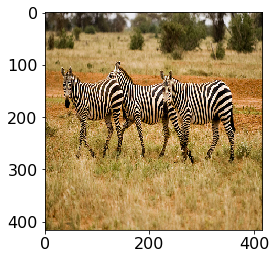

In [6]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

# load yolov3 model and perform object detection

# load yolov3 model
model_yolo3 = load_model('yolov3.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model_yolo3.predict(image)
# summarize the shape of the list of arrays
print('The output from YOLO-v3 is a list of arrays of the following shapes')
print([a.shape for a in yhat])

plt.figure()
plt.imshow(np.squeeze(image))
plt.show()

When we plot the processed image, we note that the `load_image_pixels` function appears to simply reshape the image to the desired dimensions without condideration for the aspect ratio of the image.

We also notice that the prediction from YOLO-v3 is a list of arrays.  We need to somehow interpret those arrays in order to understand what has been predicted.  The following functions provide the means to interpret those arrays in terms of what objects have been detected and where in the image they have been detected.

### Functions to decode YOLO-v3 output and plot object detection results

In [7]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
    # show the plot
    plt.show()

###  Display detection results for example image
The anchors defined in the code below are associated with the anchor boxes used in the YOLO networks.  These anchor boxes essentially define expected aspect ratios for objects in images and are used to "anchor" the detected bounding boxes.  The anchor boxes defined here are selected as good for the MSCOCO dataset.

There is also a `class_threshold` specified below.  This threshold changes the tolerance for accepting an object detection.  If we make this smaller, objects with less confidence will be included in the prediction.

There is additionally a threshold (the second parameters in the `do_nms` function call) for the non-maxima suppression of the boxes.  If we increase that value, we will find more overlapping (and potentially conflicting) bounding boxes in the prediction.

Finally, there are the list of 80 objects from the MSCOCO dataset which will be used to annotate the object detections on the image.

zebra 94.91056799888611
zebra 99.86329674720764
zebra 96.87087535858154


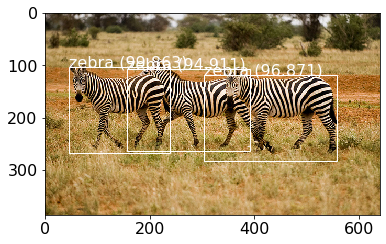

In [8]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

# load yolov3 model and perform object detection

# load yolov3 model
model_yolo3 = load_model('yolov3.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model_yolo3.predict(image)

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

## **<span style='color:Green'> Your turn: </span>**
Modify the code above to see how the network behaves on different images, or with different parameter choices, especially for the `class_threshold` or the `do_nms` threshold.  For your convenience, the code from the cell above has been copied down below for you to modify.

cake 10.777545720338821
diningtable 13.530464470386505


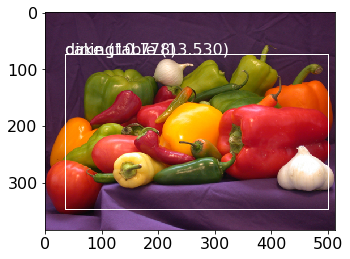

In [11]:
# the following code adapted from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
# which based the code on https://github.com/experiencor/keras-yolo3 (see MIT License statement above)

# load yolov3 model and perform object detection

# load yolov3 model
model_yolo3 = load_model('yolov3.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'peppers.png'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model_yolo3.predict(image)

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.1
boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.9)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

# Section 2 Mask-RCNN for Object Segmentation

In this section, we look at the use of the Mask-RCNN network for delineation of objects in images.  The Mask-RCNN paper can be found here: https://arxiv.org/pdf/1703.06870.pdf

The code in this section The code in this section was taken and modified (slightly) from: https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

This code took some extra work to get installed and working on my machine.  I include below some tips for other users, but note that this may be very specific to your OS and/or to your tensorflow version.  Some of these steps are from the url above, but some are gathered from my own experience.

**Step 1**: In the desired directory on your machine, download the Mask-RCNN implemented by matterport with the following command typed at your command prompt:
```
git clone https://github.com/matterport/Mask_RCNN.git
```
This download is about 125 MB.  The Matterport code is covered by an MIT License, copied below as reference.

**Step 2**: Create a conda environment to make sure that any subsequent installs for the Mask-RCNN do not interfere with any existing installs.  From your command prompt or conda terminal, type:

```
conda create -n mask_rcnn
```
This will install a conda environment called `mask_rcnn`.  You can choose any other name you desire.

**Step 3**: Activate your new conda environment by typing the following from your command prompt or conda terminal:
```
conda activate mask_rcnn
```

**Step 4**: Install pip in your conda environment by typing the following from your command prompt or conda terminal:
```
conda install pip
```

**Step5**: Navigate to the `Mask_RCNN` directory created by the git download and then run the following from your command prompt or conda terminal:
```
python setup.py install
```
If this command runs successfully, you should see the following message at the end of the setup process.
```
Finished processing dependencies for mask-rcnn==2.1
```
If you run the following command, 
```
pip show mask-rcn
```
you should get an output similar to the following as yet another indication of a successful install.
```
Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /home/lboucher/anaconda3/envs/mask_rcnn/lib/python3.8/site-packages/mask_rcnn-2.1-py3.8.egg
Requires: 
Required-by: 
```

**Step 6**: Download the Mask RCNN weights trained on the MSCOCO dataset from https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5.  This download is 246 MB.

**Step 7**: (the really fun step) Unless you happend to be running *exactly* the right tensorflow version, you will get a bunch of errors when running one or more of the code cells below.  I was able to get this code working with my version of tensorflow (2.1.0) by very carefully changing individual lines of code in the `Mask_RCNN/mrcnn/model.py` code.  I changed these lines one by one as I encountered errors.  All of these errors had to do with deprecated syntax in tensorflow.  I needed to change all instances of the following (your mileage may vary depending on your version of tensorflow):
 - `tf.log` -> `tf.math.log`
 - `tf.sets.set_intersection` -> `tf.sets.intersection`
 - `tf.sparse_tensor_to_dense` -> `tf.sparse_to_dense`
 - `tf.to_float` -> `tf.cast(...,tf.float32)`
It is also important to note that you need to be very careful to actually reload the mrcnn module after each change to `Mask_RCNN/mrcnn/model.py` code.

In [13]:
import tensorflow as tf
print(tf.__version__)

2.1.0


License information for the matterport Mask-RCNN code at https://github.com/matterport/Mask_RCNN:

Mask R-CNN
  
The MIT License (MIT)

Copyright (c) 2017 Matterport, Inc.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.   

### Detect an object in an image and visualize the segmentation mask
The code below loads in an example image `elephant.jpg` available from https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/elephant.jpg, and sends the image through the Mask-RCNN network.  The following class `TestConfig` is used as part of the configuration of the `MaskRCNN` class.

In [14]:
# the following code adapted from 
# https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

# define the test configuration
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80

The code below uses a list of the MSCOCO labels similar to the example in Section 1, but includes an 81st label for background `'BG'`.

The code below additionally uses a method `display_instances` included as part of the `MaskRCNN` class defined as part of the software we downloaded.  This `display_instances` code will interpret the output form the Mask-RCNN network and visualize the object detection.

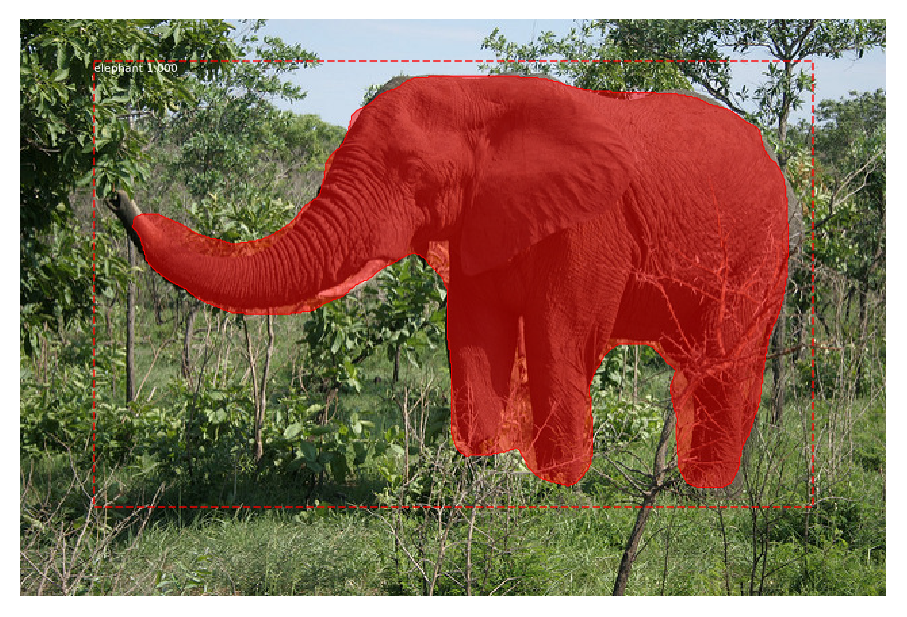

In [15]:
# the following code adapted from 
# https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

# example of inference with a pre-trained coco model
 
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('elephant.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

We see that the Mask-RCNN has detected the elephant in the image and outlined it with a bounding box and a confidence score.  It also visualizes the segmentation mask overlying the detected object.

We note here that, unfortunately, the MaskRCNN class provided as part of the downloaded software does not appear to include a summary method to display the characteristics of the network.  We would need to read through the code in the `Mask_RCNN/mrcnn/model.py` file to determine more details about the network.

We also notice that many of the potentially tuneable parameters are not as obvious in the code.  They may be options available in the `MaskRCNN` class, or it might require modification of the underlying python code.

In [16]:
rcnn.summary()

AttributeError: 'MaskRCNN' object has no attribute 'summary'

### Modify the code to outline multiple objects
In the code below, instead of using only the first prediction, we loop over all the predictions and label each separately.

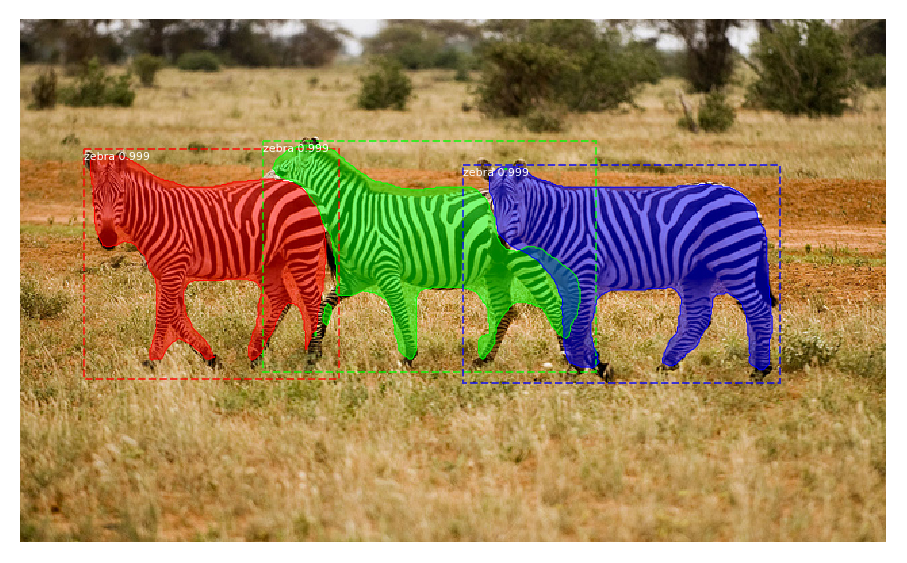

In [17]:
# the following code adapted from 
# https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('zebra.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# plot all prediction results
for r in results:
    # show photo with bounding boxes, masks, class labels and scores
    display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

## **<span style='color:Green'> Your turn: </span>**
Modify the code above to see how the network behaves on different images.  For your convenience, the code from the cell above has been copied down below for you to modify.

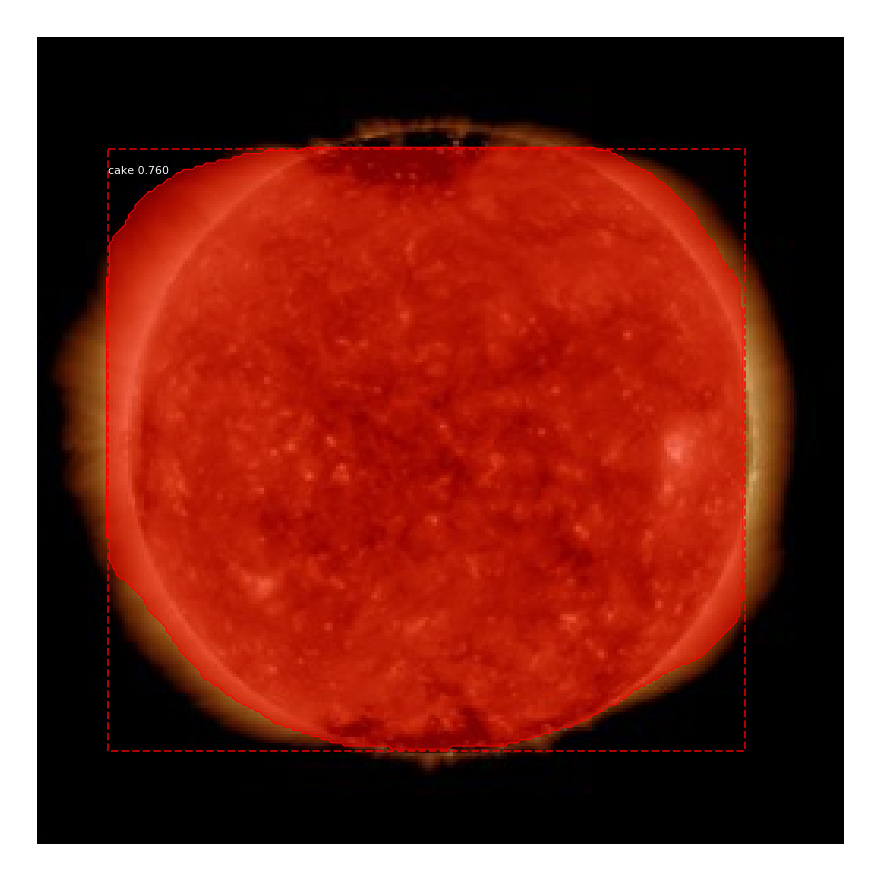

In [18]:
# the following code adapted from 
# https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/

# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('latest_256_0193.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# plot all prediction results
for r in results:
    # show photo with bounding boxes, masks, class labels and scores
    display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

# Section 3: Time Series Prediction with an LSTM

In this section, we look at the use of an LSTM (Long Short-Term Memory) network for time-series prediction.  LSTMs are a form of Recurrent Neural Networks (RNNs) that can learn from temporal sequences of data.

This example has been adapted from https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ and will use a small dataset consisting of the number of airline passengers each month from January 1949 to December 1960.  The dataset can be downloaded from: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv.  Note that although the url specifies that this is a `.csv` file, it is actually a `.txt` file.

The ultimate goal will be, given some amount of "history" in this data to predict the "future" demand.

### Set random seed

In [19]:
# the following code adapted from 
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# fix random seed for reproducibility
np.random.seed(42)

### Take a quick look at this data
In the following code, the first column of the data (the date) is discarded since all the data are evenly spaced one month apart.

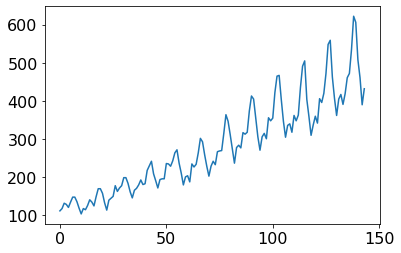

In [20]:
# the following code adapted from 
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# load the dataset
dataframe = pd.read_csv('airline-passengers.txt', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

### Normalize the dataset and split into train and test sets
The following code uses the `MinMaxScaler` function from `sklearn.preprocessing` to normalize the data to the range [0,1].  The first two thirds of the dataset is set aside for training (the history) and the last third will be used to compare to the model prediction.

In [21]:
# the following code adapted from 
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


### Define function to rearrange data 
The following function rearranges the time series data into windows of data of length `look_back` which are used to predict the subsequent value.  This function is defined to be general so that we can use it for any length of `look_back` windows.

In [22]:
# the following code adapted from 
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

###  Define data for a look-back window of 1 sample

In [23]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## **<span style='color:Green'> Your turn: </span>**
Explore the contents of the training and test data.  It might be helpful to open the `airline-passengers.txt` file in a text editor to see how it the `trainX`, `trainY`, `testX`, and `testY` variable relate to the original data.  Remember, however, that the data has been normalized to the range [0,1].  We can use the `scaler.inverse_transform` method to reverse the scaling.

In [24]:
scaler.inverse_transform(testX)

array([[315.     ],
       [301.     ],
       [356.     ],
       [348.     ],
       [355.     ],
       [421.99997],
       [465.     ],
       [466.99997],
       [403.99997],
       [347.     ],
       [305.     ],
       [336.     ],
       [340.     ],
       [318.     ],
       [362.     ],
       [348.     ],
       [363.     ],
       [434.99997],
       [491.     ],
       [505.     ],
       [403.99997],
       [359.     ],
       [310.     ],
       [337.     ],
       [360.     ],
       [342.     ],
       [406.     ],
       [395.99997],
       [420.     ],
       [471.99997],
       [548.     ],
       [559.     ],
       [462.99997],
       [407.     ],
       [362.     ],
       [404.99997],
       [416.99997],
       [390.99997],
       [418.99997],
       [461.     ],
       [471.99997],
       [535.     ],
       [622.     ],
       [606.     ],
       [507.99997],
       [461.     ]], dtype=float32)

### Wrangle tensor dimensionality
The LSTM will expect input to be in the form samples$\times$look-back$\times$features.  Samples is the number of example sequences we have, look-back is the number of time steps in each of those sequences, and features are the actual times sequences.

In [25]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
trainX.shape

(94, 1, 1)

## **<span style='color:Green'> Your turn: </span>**
Explore the dimensionality and/or contents of the training and test data now.

In [27]:
trainX.shape

(94, 1, 1)

### Important note about re-running individual code blocks
If you re-run individual code blocks up above, you may inadvertently duplicate reshaping, etc.  If you end up with dimensionality errors below, start back up at the beginning of this section and run the code cells in sequence again.  After we finish this example, the entire code will be copied into a single code cell to avoid these duplication issues.

### Define the LSTM and fit to the training data
The network defined below is very small--one hidden layer consisting of four LSTM neurons.  Note that since this is a problem of regression (predicting a continuous-valued output rather than a category), the loss is `'mean_squared_error'`.

In [28]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 13ms/step - loss: 0.0409
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0081
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 11/100
94/94 [==============================] - 1s 7ms/step - loss: 0.0056
Epoch 12/100
94/94 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 13/100
94/94 [================

### Predict the rest of the time sequence
Now that the LSTM is trained, we can use it to predict the rest of the sequence.  Remember that the network has not seen any of the data from the last third of the sequence.  We also use it to predict the first two thirds of the sequence, expecting that there is likely some small deviation due to model errors.

In [29]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.74 RMSE
Test Score: 50.89 RMSE


### Plot and compare the prediction to truth
Some care needs to be taken in plotting the predicted sequences since there is a window of values before the network can make a prediction.  This means that the predicted sequence for train and for test is slightly shorter than the original train and test sequences.

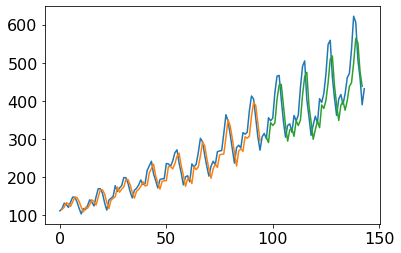

In [30]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## **<span style='color:Green'> Your turn: </span>**
Try choosing a different look-back window and see the effects on the prediction.  You can also try changing the architecture of the LSTM if you wish.

Epoch 1/100
 - 1s - loss: 0.0444
Epoch 2/100
 - 0s - loss: 0.0103
Epoch 3/100
 - 0s - loss: 0.0085
Epoch 4/100
 - 0s - loss: 0.0063
Epoch 5/100
 - 0s - loss: 0.0056
Epoch 6/100
 - 0s - loss: 0.0045
Epoch 7/100
 - 0s - loss: 0.0049
Epoch 8/100
 - 0s - loss: 0.0042
Epoch 9/100
 - 0s - loss: 0.0041
Epoch 10/100
 - 0s - loss: 0.0037
Epoch 11/100
 - 0s - loss: 0.0035
Epoch 12/100
 - 0s - loss: 0.0033
Epoch 13/100
 - 0s - loss: 0.0031
Epoch 14/100
 - 0s - loss: 0.0031
Epoch 15/100
 - 0s - loss: 0.0032
Epoch 16/100
 - 0s - loss: 0.0034
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0025
Epoch 19/100
 - 0s - loss: 0.0023
Epoch 20/100
 - 0s - loss: 0.0027
Epoch 21/100
 - 0s - loss: 0.0033
Epoch 22/100
 - 0s - loss: 0.0024
Epoch 23/100
 - 0s - loss: 0.0022
Epoch 24/100
 - 0s - loss: 0.0020
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0022
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0019
Epoch 29/100
 - 0s - loss: 0.0018
Epoch 30/100
 - 0s - lo

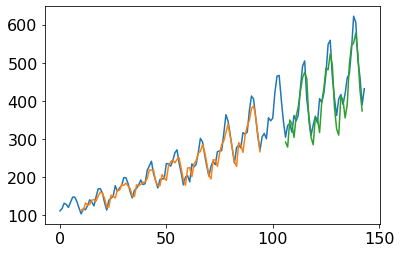

In [32]:
# fix random seed for reproducibility
np.random.seed(42)
# load the dataset
dataframe = pd.read_csv('airline-passengers.txt', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1024, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Food for thought:
How might you somehow combine the capabilities of a CNN or classical machine learning for image analysis with an LSTM for sequence analysis to be able to analyze spatiotemporal information?  